In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision

import pickle
import torch
import os
import copy
import torch.nn as nn
import seaborn as sns


/home/zsarwar/.conda/envs/cnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Plots
import matplotlib.pyplot as plt

def plot_side_by_side(image1, image2, idx, save_path, titles=None):
    """
    Plots three images side by side.

    Args:
        image1 (np.ndarray): The first image.
        image2 (np.ndarray): The second image.
        image3 (np.ndarray): The third image.
        titles (list, optional): A list of titles for the images.

    Returns:
        None
    """

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].set_title(titles[0])
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[1].set_title(titles[1])
    axes[1].imshow(image2)
    axes[1].axis('off')
    
    plt.tight_layout()
    
    if save_path is not None:
        filename = os.path.join(save_path, f"{idx}.jpg")
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

    
def lineplot_acc_perturbation(x, y1,y2, title, xlabel, ylabel, config, base_path):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y1, label='Accuracy - Layer-wise Regularized')
    plt.plot(x, y2, label='Accuracy - Regularized')
    plt.legend(loc='upper right')        
    filename = os.path.join(base_path, config + ".jpg")
    plt.savefig(filename, bbox_inches='tight')
    
def lineplot_l2radius_perturbation(x, y1, y2, title, xlabel, ylabel, config, base_path):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y1, label="Layer-wise Regularized")
    plt.plot(x, y2, label="Regularized")
    plt.legend(loc='upper left')
    filename = os.path.join(base_path, config + ".jpg")
    plt.savefig(filename, bbox_inches='tight')
    

def plot_histplot(df, color, label, title, ylim, xlabel, ylabel, base_path, plot_config, auto_bins=False):
    df = df.copy()
    unique_bins = len(df[label].dropna().unique())
    if auto_bins:
        ax = sns.histplot(data=df, x=label, color=color, label=label, bins='auto')
    else:
        ax = sns.histplot(data=df, x=label, color=color, label=label, bins=unique_bins)
    ax.set_ylim(0, ylim)
    ax.set_xlim(0)
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=90)
    ax.set(ylabel=ylabel)
    plt.title(title)
    ax.legend()
    ax.set(xlabel=xlabel)
    out_path = os.path.join(base_path, plot_config)
    plt.savefig(out_path, bbox_inches='tight')
    plt.close()



In [3]:
all_base_paths = ["/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_f9c2570b43d17cd3f46b942f31d6fb03", 
                  "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_a75d060c2415e722a953e03729658a14",
                  "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_604c7156b94d79a9430e2f87fd6d30ea",
                  "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_43528ed29912dd1a3825f30bea8e4ba8",
                  "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_814e4c261078e7110bf94f724cd2187e",
                  "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_33a81207624e6e5c14135c2eeb851fb7"
                  ]

MSELoss_none = nn.MSELoss(reduction='none')
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()
num_samples = 2560
og_num_samples = 2560
detector = 'Regular'
c_base=0.3
d_base=0.0
all_eps_list=[[0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04],
            [0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04, 
            0.042, 0.044, 0.046, 0.048, 0.05, 0.052, 0.054, 0.056, 0.058, 0.060, 0.062, 0.064, 0.066, 0.068],
            #[0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032],
            [0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04, 
            0.042, 0.044, 0.046, 0.048, 0.05, 0.052, 0.054, 0.056, 0.058, 0.060, 0.062, 0.064, 0.066, 0.068],
            [0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032],
            [0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032],
            [0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04, 
            0.042, 0.044, 0.046, 0.048, 0.05, 0.052, 0.054, 0.056, 0.058, 0.060, 0.062, 0.064, 0.066, 0.068],]

plot_path = os.path.join(all_base_paths[0], "Plots")

In [4]:

all_freq_lists = []
all_theoretical_eps_per_channel = []
all_mse_loss_per_channel = []
all_mse_loss_per_pixel = []
all_mse_max_per_pixel = []
all_mse_loss_per_image = []
    
for eps_idx, base_path in enumerate(all_base_paths):
    if "MT_Baseline_600547deae5b3d506d5c0befd9134c77" in base_path or "MT_Baseline_814e4c261078e7110bf94f724cd2187e" in base_path or "MT_Baseline_43528ed29912dd1a3825f30bea8e4ba8" in base_path:
        num_samples = 1500
        c_base=1.0
    elif "MT_Baseline_604c7156b94d79a9430e2f87fd6d30ea" in base_path or "MT_Baseline_33a81207624e6e5c14135c2eeb851fb7" in base_path:
        num_samples = 3560
        c_base=1.0
    else:
        num_samples = og_num_samples
        c_base=0.3
    all_flipped_indices = []
    lst_theoretical_eps_per_channel = []
    lst_mse_loss_per_channel = []
    lst_mse_loss_per_pixel = []
    lst_mse_max_per_pixel = []
    lst_mse_loss_per_image = []

    prev_flipped_indices = set()
    for eps in (all_eps_list[eps_idx]):
        images_cw_base = f"Adversarial_Datasets/CW_adv_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        images_benign = f"Benign_Datasets/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        predictions_base = f"Predictions/Model/CW_type-adversarial_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pt"
        images_cw_base = os.path.join(base_path, images_cw_base)
        images_benign = os.path.join(base_path, images_benign)
        predictions_base_path = os.path.join(base_path, predictions_base)
        filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)

        # Filter by common indices
        filtered_indices_base = torch.load(filtered_indices_base_path)
        filtered_indices_base = [x.item() for x in filtered_indices_base]
        curr_flipped_indices = set(filtered_indices_base)
        curr_unique_flipped_indices = curr_flipped_indices.difference(prev_flipped_indices)    
        prev_flipped_indices.update(curr_unique_flipped_indices)
        curr_unique_flipped_indices = list(curr_unique_flipped_indices)
        all_flipped_indices.append(filtered_indices_base)

        with open(images_cw_base, 'rb') as in_file:
            images_cw_base = pickle.load(in_file)
            images_cw_base[0] = images_cw_base[0][curr_unique_flipped_indices]
            images_cw_base[1] = images_cw_base[1][curr_unique_flipped_indices]
            
        with open(images_benign, 'rb') as in_file:
            images_benign = pickle.load(in_file)
            images_benign[0] = images_benign[0][curr_unique_flipped_indices]
            images_benign[1] = images_benign[1][curr_unique_flipped_indices]

        with open(predictions_base_path, 'rb') as in_file:
            predictions = pickle.load(in_file)
            true_labels_base = np.asarray(predictions['true_labels'])[curr_unique_flipped_indices]
            pred_labels_base = np.asarray(predictions['pred_labels'])[curr_unique_flipped_indices]

        mse_loss_per_channel = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_channel = torch.sqrt(mse_loss_per_channel)
        mse_loss_per_channel = mse_loss_per_channel.mean(dim=1)
        lst_mse_loss_per_channel.append(mse_loss_per_channel.tolist())
        lst_theoretical_eps_per_channel.append([eps for i in range(len(curr_unique_flipped_indices)) ])

        #print(f"L2 per channel : {mse_loss_per_channel}")

        """
        mse_loss_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_loss_per_pixel = torch.sqrt(mse_loss_per_pixel.sum(dim=1)).flatten(1).mean(dim=1).mean()
        lst_mse_loss_per_pixel.append(mse_loss_per_pixel.item())
        #print(f"L2 per pixel : {mse_loss_per_pixel}")

        mse_max_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_max_per_pixel = torch.sqrt(mse_max_per_pixel.sum(dim=1).flatten(1).max(dim=1)[0]).mean()
        lst_mse_max_per_pixel.append(mse_max_per_pixel.item())
        #print(f"L2 max pixel : {mse_max_per_pixel}")

        mse_loss_per_image = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_image = torch.sqrt(mse_loss_per_image.sum(dim=1)).mean()
        lst_mse_loss_per_image.append(mse_loss_per_image.item())
        #print(f"L2 per image : {mse_loss_per_image}")
        """

    lst_mse_loss_per_channel = [x for lst in lst_mse_loss_per_channel for x in lst]
    lst_theoretical_eps_per_channel = [x for lst in lst_theoretical_eps_per_channel for x in lst]
    """all_counts
    lst_mse_loss_per_pixel = np.round(np.asarray(lst_mse_loss_per_pixel),decimals=4)
    lst_mse_max_per_pixel = np.round(np.asarray(lst_mse_max_per_pixel),decimals=4)
    lst_mse_loss_per_image = np.round(np.asarray(lst_mse_loss_per_image),decimals=4)
    """

    # Append to main lists
    all_mse_loss_per_channel.append(lst_mse_loss_per_channel.copy())
    all_theoretical_eps_per_channel.append(lst_theoretical_eps_per_channel.copy())

    """
    all_mse_loss_per_pixel.append(lst_mse_loss_per_pixel)
    all_mse_max_per_pixel.append(lst_mse_max_per_pixel)
    all_mse_loss_per_image.append(lst_mse_loss_per_image)
    """
    



#all_mse_loss_per_channel = np.asarray(all_mse_loss_per_channel, dtype=object)
"""
all_mse_loss_per_pixel = np.asarray(all_mse_loss_per_pixel, dtype=object)
all_mse_max_per_pixel = np.asarray(all_mse_max_per_pixel, dtype=object)
all_mse_loss_per_image = np.asarray(all_mse_loss_per_image, dtype=object)
"""
    






'\nall_mse_loss_per_pixel = np.asarray(all_mse_loss_per_pixel, dtype=object)\nall_mse_max_per_pixel = np.asarray(all_mse_max_per_pixel, dtype=object)\nall_mse_loss_per_image = np.asarray(all_mse_loss_per_image, dtype=object)\n'

# Theoretical Epsilon - Channelwise

/tmp/ipykernel_3321190/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3321190/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3321190/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3321190/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3321190/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a F

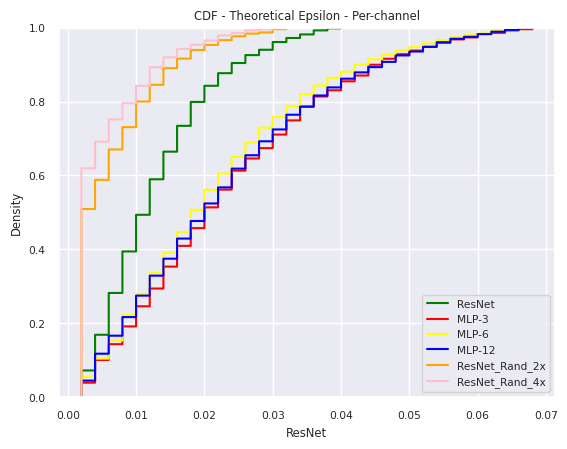

In [5]:



# Preprocess for Nones
max_count = max(len(x) for x in all_theoretical_eps_per_channel)
max_eps_list = max(enumerate(all_theoretical_eps_per_channel), key=lambda m : len(m[1]) )[0]

for i in range(len(all_mse_loss_per_channel)):
    none_arr = [np.nan for k in range(max_count - len(all_theoretical_eps_per_channel[i]))]
    all_theoretical_eps_per_channel[i].extend(none_arr)


all_theoretical_eps_per_channel = np.round(all_theoretical_eps_per_channel, decimals=8)



# Create sample dataset
arch_rob = {"ResNet" : all_theoretical_eps_per_channel[0], "MLP-3" : all_theoretical_eps_per_channel[1],  "MLP-6": all_theoretical_eps_per_channel[2],"ResNet_Rand_2x" : all_theoretical_eps_per_channel[3], "ResNet_Rand_4x" : all_theoretical_eps_per_channel[4],
                    "MLP-12" : all_theoretical_eps_per_channel[5] }
df = pd.DataFrame.from_dict(arch_rob)
sns.set(font_scale=0.7)

base_path = plot_path

plot_config = "theoretical_epsilon_ResNet.jpg"
plot_histplot(df=df, color='green', label='ResNet', title="PDF - Theoretical Epsilon - Per-channel", ylim=270, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config)


plot_config = "theoretical_epsilon_MLP-3.jpg"
plot_histplot(df=df, color='red', label='MLP-3', title="PDF - Theoretical Epsilon - Per-channel", ylim=150, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config )


plot_config = "theoretical_epsilon_MLP-6.jpg"
plot_histplot(df=df, color='yellow', label='MLP-6', title="PDF - Theoretical Epsilon - Per-channel", ylim=200, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config )


plot_config = "theoretical_epsilon_MLP-12.jpg"
plot_histplot(df=df, color='blue', label='MLP-12', title="PDF - Theoretical Epsilon - Per-channel", ylim=200, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config )

plot_config = "theoretical_epsilon_ResNet_Rand_2x.jpg"
plot_histplot(df=df, color='orange', label='ResNet_Rand_2x', title="PDF - Theoretical Epsilon - Per-channel", ylim=650, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config)

plot_config = "theoretical_epsilon_ResNet_Rand_4x.jpg"
plot_histplot(df=df, color='pink', label='ResNet_Rand_4x', title="PDF - Theoretical Epsilon - Per-channel", ylim=800, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config )

# Plot CDFs
ax = sns.ecdfplot(data=df, x='ResNet', color='green', label='ResNet')
ax = sns.ecdfplot(data=df, x='MLP-3', color='red', label='MLP-3', ax=ax)
ax = sns.ecdfplot(data=df, x='MLP-6', color='yellow', label='MLP-6')
ax = sns.ecdfplot(data=df, x='MLP-12', color='blue', label='MLP-12')
ax = sns.ecdfplot(data=df, x='ResNet_Rand_2x', color='orange', label='ResNet_Rand_2x')
ax = sns.ecdfplot(data=df, x='ResNet_Rand_4x', color='pink', label='ResNet_Rand_4x')
ax.set(ylabel='Density')
plt.title("CDF - Theoretical Epsilon - Per-channel")
ax.legend()
plot_config = "theoretical_epsilon_cdf.jpg"
out_path = os.path.join(plot_path, plot_config)
plt.savefig(out_path, bbox_inches='tight')



# Empiricial Epsilon - Channelwise

/tmp/ipykernel_3321190/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3321190/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3321190/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3321190/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3321190/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a F

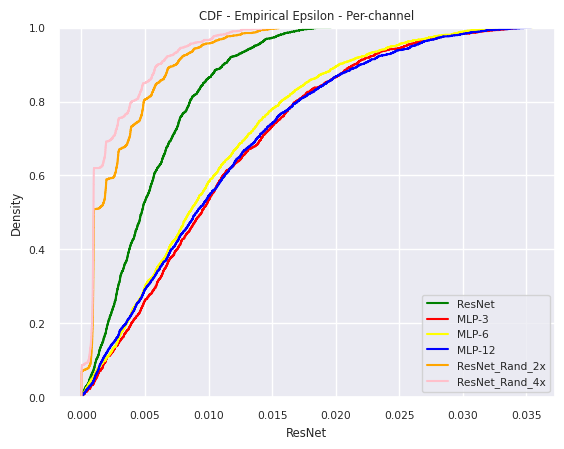

In [6]:

# Preprocess for Nones
max_count = max(len(x) for x in all_mse_loss_per_channel)
max_eps_list = max(enumerate(all_mse_loss_per_channel), key=lambda m : len(m[1]) )[0]

for i in range(len(all_mse_loss_per_channel)):
    none_arr = [np.nan for k in range(max_count - len(all_mse_loss_per_channel[i]))]
    all_mse_loss_per_channel[i].extend(none_arr)


all_mse_loss_per_channel = np.round(all_mse_loss_per_channel, decimals=8)



# Create sample dataset
arch_rob = {"ResNet" : all_mse_loss_per_channel[0], "MLP-3" : all_mse_loss_per_channel[1],  "MLP-6": all_mse_loss_per_channel[2],"ResNet_Rand_2x" : all_mse_loss_per_channel[3], "ResNet_Rand_4x" : all_mse_loss_per_channel[4],
            "MLP-12" : all_mse_loss_per_channel[5] }
df = pd.DataFrame.from_dict(arch_rob)





sns.set(font_scale=0.7)

base_path = plot_path

plot_config = "empirical_epsilon_ResNet.jpg"
plot_histplot(df=df, color='green', label='ResNet', title="PDF - Empirical Epsilon - Per-channel", ylim=270, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config, auto_bins=True)


plot_config = "empirical_epsilon_MLP-3.jpg"
plot_histplot(df=df, color='red', label='MLP-3', title="PDF - Empirical Epsilon - Per-channel", ylim=300, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config,auto_bins=True )


plot_config = "empirical_epsilon_MLP-6.jpg"
plot_histplot(df=df, color='yellow', label='MLP-6', title="PDF - Empirical Epsilon - Per-channel", ylim=300, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config, auto_bins=True )


plot_config = "empirical_epsilon_MLP-12.jpg"
plot_histplot(df=df, color='blue', label='MLP-12', title="PDF - Empirical Epsilon - Per-channel", ylim=300, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config, auto_bins=True )

plot_config = "empirical_epsilon_ResNet_Rand_2x.jpg"
plot_histplot(df=df, color='orange', label='ResNet_Rand_2x', title="PDF - Empirical Epsilon - Per-channel", ylim=600, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config, auto_bins=True)

plot_config = "empirical_epsilon_ResNet_Rand_4x.jpg"
plot_histplot(df=df, color='pink', label='ResNet_Rand_4x', title="PDF - Empirical Epsilon - Per-channel", ylim=600, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config, auto_bins=True )


# Plot CDFs

ax = sns.ecdfplot(data=df, x='ResNet', color='green', label='ResNet')
ax = sns.ecdfplot(data=df, x='MLP-3', color='red', label='MLP-3', ax=ax)
ax = sns.ecdfplot(data=df, x='MLP-6', color='yellow', label='MLP-6')
ax = sns.ecdfplot(data=df, x='MLP-12', color='blue', label='MLP-12')
ax = sns.ecdfplot(data=df, x='ResNet_Rand_2x', color='orange', label='ResNet_Rand_2x')
ax = sns.ecdfplot(data=df, x='ResNet_Rand_4x', color='pink', label='ResNet_Rand_4x')
ax.set(ylabel='Density')
plt.title("CDF - Empirical Epsilon - Per-channel")
ax.legend()
plot_config = "empirical_epsilon_channelwise_cdf.jpg"
out_path = os.path.join(plot_path, plot_config)
plt.savefig(out_path, bbox_inches='tight')



# Empirical Epsilon

In [4]:

all_freq_lists = []
all_counts = []
all_mse_loss_per_channel = []
all_mse_loss_per_pixel = []
all_mse_max_per_pixel = []
all_mse_loss_per_image = []
    
for eps_idx, base_path in enumerate(all_base_paths):
    if "MT_Baseline_600547deae5b3d506d5c0befd9134c77" in base_path or "MT_Baseline_814e4c261078e7110bf94f724cd2187e" in base_path or "MT_Baseline_43528ed29912dd1a3825f30bea8e4ba8" in base_path:
        num_samples = 1500
        c_base=1.0
    elif "MT_Baseline_604c7156b94d79a9430e2f87fd6d30ea" in base_path or "MT_Baseline_33a81207624e6e5c14135c2eeb851fb7" in base_path:

        num_samples = 3560
        c_base=1.0
    else:
        num_samples = og_num_samples
        c_base=0.3
    all_flipped_indices = []
    lst_mse_loss_per_channel = []
    lst_mse_loss_per_pixel = []
    lst_mse_max_per_pixel = []
    lst_mse_loss_per_image = []

    prev_flipped_indices = set()
    for eps in (all_eps_list[eps_idx]):
        images_cw_base = f"Adversarial_Datasets/CW_adv_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        images_benign = f"Benign_Datasets/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        predictions_base = f"Predictions/Model/CW_type-adversarial_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pt"
        images_cw_base = os.path.join(base_path, im
# Preprocess for Nones
max_count = max(len(x) for x in all_mse_loss_per_channel)
max_eps_list = max(enumerate(all_mse_loss_per_channel), key=lambda m : len(m[1]) )[0]

for i in range(len(all_mse_loss_per_channel)):
    none_arr = [np.nan for k in range(max_count - len(all_mse_loss_per_channel[i]))]
    all_mse_loss_per_channel[i].extend(none_arr)


all_mse_loss_per_channel = np.round(all_mse_loss_per_channel, decimals=8)



# Create sample dataset
arch_rob = {"ResNet" : all_mse_loss_per_channel[0], "MLP-3" : all_mse_loss_per_channel[1],  "MLP-6": all_mse_loss_per_channel[2],"ResNet_Rand_2x" : all_mse_loss_per_channel[3], "ResNet_Rand_4x" : all_mse_loss_per_channel[4],
            "MLP-12" : all_mse_loss_per_channel[5] }
df = pd.DataFrame.from_dict(arch_rob)

filtered_indices_base]
        curr_flipped_indices = set(filtered_indices_base)
        curr_unique_flipped_indices = curr_flipped_indices.difference(prev_flipped_indices)    
        prev_flipped_indices.update(curr_unique_flipped_indices)
        curr_unique_flipped_indices = list(curr_unique_flipped_indices)
        all_flipped_indices.append(filtered_indices_base)

        with open(images_cw_base, 'rb') as in_file:
            images_cw_base = pickle.load(in_file)
            images_cw_base[0] = images_cw_base[0][curr_unique_flipped_indices]
            images_cw_base[1] = images_cw_base[1][curr_unique_flipped_indices]
            
        with open(images_benign, 'rb') as in_file:
            images_benign = pickle.load(in_file)
            images_benign[0] = images_benign[0][curr_unique_flipped_indices]
            images_benign[1] = images_benign[1][curr_unique_flipped_indices]

        with open(predictions_base_path, 'rb') as in_file:
            predictions = pickle.load(in_file)
            true_labels_base = np.asarray(predictions['true_labels'])[curr_unique_flipped_indices]
            pred_labels_base = np.asarray(predictions['pred_labels'])[curr_unique_flipped_indices]

        mse_loss_per_channel = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_channel = torch.sqrt(mse_loss_per_channel)
        mse_loss_per_channel = mse_loss_per_chan
# Preprocess for Nones
max_count = max(len(x) for x in all_mse_loss_per_channel)
max_eps_list = max(enumerate(all_mse_loss_per_channel), key=lambda m : len(m[1]) )[0]

for i in range(len(all_mse_loss_per_channel)):
    none_arr = [np.nan for k in range(max_count - len(all_mse_loss_per_channel[i]))]
    all_mse_loss_per_channel[i].extend(none_arr)


all_mse_loss_per_channel = np.round(all_mse_loss_per_channel, decimals=8)



# Create sample dataset
arch_rob = {"ResNet" : all_mse_loss_per_channel[0], "MLP-3" : all_mse_loss_per_channel[1],  "MLP-6": all_mse_loss_per_channel[2],"ResNet_Rand_2x" : all_mse_loss_per_channel[3], "ResNet_Rand_4x" : all_mse_loss_per_channel[4],
            "MLP-12" : all_mse_loss_per_channel[5] }
df = pd.DataFrame.from_dict(arch_rob)


        """
        mse_loss_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_loss_per_pixel = torch.sqrt(mse_loss_per_pixel.sum(dim=1)).flatten(1).mean(dim=1).mean()
        lst_mse_loss_per_pixel.append(mse_loss_per_pixel.item())
        #print(f"L2 per pixel : {mse_loss_per_pixel}")

        mse_max_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_max_per_pixel = torch.sqrt(mse_max_per_pixel.sum(dim=1).flatten(1).max(dim=1)[0]).mean()
        lst_mse_max_per_pixel.append(mse_max_per_pixel.item())
        #print(f"L2 max pixel : {mse_max_per_pixel}")

        mse_loss_per_image = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_image = torch.sqrt(mse_loss_per_image.sum(dim=1)).mean()
        lst_mse_loss_per_image.append(mse_loss_per_image.item())
        #print(f"L2 per image : {mse_loss_per_image}")
        """

    lst_mse_loss_per_channel = [x for lst in lst_mse_loss_per_channel for x in lst]
    """
    lst_mse_loss_per_pixel = np.round(np.asarray(lst_mse_loss_per_pixel),decimals=4)
    lst_mse_max_per_pixel = np.round(np.asarray(l
# Preprocess for Nones
max_count = max(len(x) for x in all_mse_loss_per_channel)
max_eps_list = max(enumerate(all_mse_loss_per_channel), key=lambda m : len(m[1]) )[0]

for i in range(len(all_mse_loss_per_channel)):
    none_arr = [np.nan for k in range(max_count - len(all_mse_loss_per_channel[i]))]
    all_mse_loss_per_channel[i].extend(none_arr)


all_mse_loss_per_channel = np.round(all_mse_loss_per_channel, decimals=8)



# Create sample dataset
arch_rob = {"ResNet" : all_mse_loss_per_channel[0], "MLP-3" : all_mse_loss_per_channel[1],  "MLP-6": all_mse_loss_per_channel[2],"ResNet_Rand_2x" : all_mse_loss_per_channel[3], "ResNet_Rand_4x" : all_mse_loss_per_channel[4],
            "MLP-12" : all_mse_loss_per_channel[5] }
df = pd.DataFrame.from_dict(arch_rob)


    all_mse_loss_per_pixel.append(lst_mse_loss_per_pixel)
    all_mse_max_per_pixel.append(lst_mse_max_per_pixel)
    all_mse_loss_per_image.append(lst_mse_loss_per_image)
    """
    



#all_mse_loss_per_channel = np.asarray(all_mse_loss_per_channel, dtype=object)
"""
all_mse_loss_per_pixel = np.asarray(all_mse_loss_per_pixel, dtype=object)
all_mse_max_per_pixel = np.asarray(all_mse_max_per_pixel, dtype=object)
all_mse_loss_per_image = np.asarray(all_mse_loss_per_image, dtype=object)
"""
    

# Preprocess for Nones
max_count = max(len(x) for x in all_mse_loss_per_channel)
max_eps_list = max(enumerate(all_mse_loss_per_channel), key=lambda m : len(m[1]) )[0]

for i in range(len(all_mse_loss_per_channel)):
    none_arr = [np.nan for k in range(max_count - len(all_mse_loss_per_channel[i]))]
    all_mse_loss_per_channel[i].extend(none_arr)


all_mse_loss_per_channel = np.round(all_mse_loss_per_channel, decimals=8)



# Create sample dataset
arch_rob = {"ResNet" : all_mse_loss_per_channel[0], "MLP-3" : all_mse_loss_per_channel[1],  "MLP-6": all_mse_loss_per_channel[2],"ResNet_Rand_2x" : all_mse_loss_per_channel[3], "ResNet_Rand_4x" : all_mse_loss_per_channel[4],
            "MLP-12" : all_mse_loss_per_channel[5] }
df = pd.DataFrame.from_dict(arch_rob)




In [5]:
sns.set(font_scale=0.7)

base_path = plot_path

plot_config = "empirical_epsilon_ResNet.jpg"
plot_histplot(df=df, color='green', label='ResNet', title="PDF - Empirical Epsilon - Per-channel", ylim=270, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config, auto_bins=True)


plot_config = "empirical_epsilon_MLP-3.jpg"
plot_histplot(df=df, color='red', label='MLP-3', title="PDF - Empirical Epsilon - Per-channel", ylim=300, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config,auto_bins=True )


plot_config = "empirical_epsilon_MLP-6.jpg"
plot_histplot(df=df, color='yellow', label='MLP-6', title="PDF - Empirical Epsilon - Per-channel", ylim=300, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config, auto_bins=True )


plot_config = "empirical_epsilon_MLP-12.jpg"
plot_histplot(df=df, color='blue', label='MLP-12', title="PDF - Empirical Epsilon - Per-channel", ylim=300, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config, auto_bins=True )

plot_config = "empirical_epsilon_ResNet_Rand_2x.jpg"
plot_histplot(df=df, color='orange', label='ResNet_Rand_2x', title="PDF - Empirical Epsilon - Per-channel", ylim=650, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config, auto_bins=True)

plot_config = "empirical_epsilon_ResNet_Rand_4x.jpg"
plot_histplot(df=df, color='pink', label='ResNet_Rand_4x', title="PDF - Empirical Epsilon - Per-channel", ylim=800, xlabel="Epsilon", ylabel="Flip count", base_path=base_path, plot_config=plot_config, auto_bins=True )


# Plot CDFs

ax = sns.ecdfplot(data=df, x='ResNet', color='green', label='ResNet')
ax = sns.ecdfplot(data=df, x='MLP-3', color='red', label='MLP-3', ax=ax)
ax = sns.ecdfplot(data=df, x='MLP-6', color='yellow', label='MLP-6')
ax = sns.ecdfplot(data=df, x='MLP-12', color='blue', label='MLP-12')
ax = sns.ecdfplot(data=df, x='ResNet_Rand_2x', color='orange', label='ResNet_Rand_2x')
ax = sns.ecdfplot(data=df, x='ResNet_Rand_4x', color='pink', label='ResNet_Rand_4x')
ax.set(ylabel='Density')
plt.title("CDF - Empirical Epsilon - Per-channel")
ax.legend()
plot_config = "empirical_epsilon_channelwise_cdf.jpg"
out_path = os.path.join(plot_path, plot_config)
plt.savefig(out_path, bbox_inches='tight')



/tmp/ipykernel_3318692/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3318692/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3318692/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3318692/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_3318692/2969893823.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a F

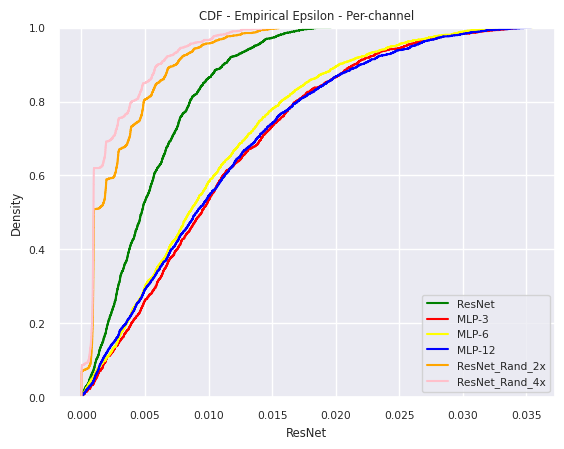

# Per Pixel Empirical

/tmp/ipykernel_4080841/1382670158.py:198: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


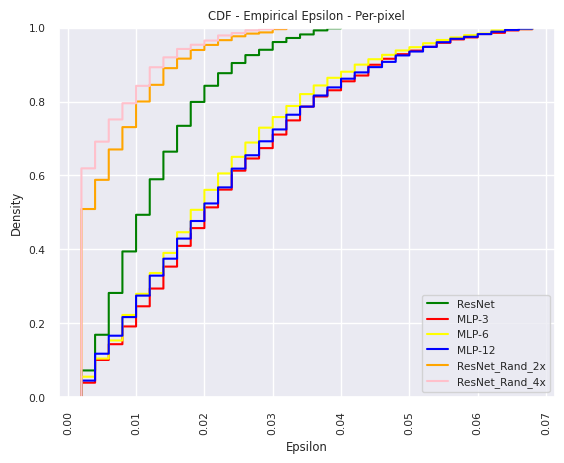

In [6]:

all_freq_lists = []
all_counts = []
all_mse_loss_per_channel = []
all_mse_loss_per_pixel = []
all_mse_max_per_pixel = []
all_mse_loss_per_image = []
    
for eps_idx, base_path in enumerate(all_base_paths):
    if "MT_Baseline_600547deae5b3d506d5c0befd9134c77" in base_path or "MT_Baseline_814e4c261078e7110bf94f724cd2187e" in base_path or "MT_Baseline_43528ed29912dd1a3825f30bea8e4ba8" in base_path:
        num_samples = 1500
        c_base=1.0
    elif "MT_Baseline_604c7156b94d79a9430e2f87fd6d30ea" in base_path or "MT_Baseline_33a81207624e6e5c14135c2eeb851fb7" in base_path:
        num_samples = 3560
        c_base=1.0
    else:
        num_samples = og_num_samples
        c_base=0.3

    all_flipped_indices = []
    lst_mse_loss_per_channel = []
    lst_mse_loss_per_pixel = []
    lst_mse_max_per_pixel = []
    lst_mse_loss_per_image = []

    prev_flipped_indices = set()
    for eps in (all_eps_list[eps_idx]):
        images_cw_base = f"Adversarial_Datasets/CW_adv_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        images_benign = f"Benign_Datasets/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        predictions_base = f"Predictions/Model/CW_type-adversarial_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pt"
        images_cw_base = os.path.join(base_path, images_cw_base)
        images_benign = os.path.join(base_path, images_benign)
        predictions_base_path = os.path.join(base_path, predictions_base)
        filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)

        # Filter by common indices
        filtered_indices_base = torch.load(filtered_indices_base_path)
        filtered_indices_base = [x.item() for x in filtered_indices_base]
        curr_flipped_indices = set(filtered_indices_base)
        curr_unique_flipped_indices = curr_flipped_indices.difference(prev_flipped_indices)    
        prev_flipped_indices.update(curr_unique_flipped_indices)
        curr_unique_flipped_indices = list(curr_unique_flipped_indices)
        all_flipped_indices.append(filtered_indices_base)

        with open(images_cw_base, 'rb') as in_file:
            images_cw_base = pickle.load(in_file)
            images_cw_base[0] = images_cw_base[0][curr_unique_flipped_indices]
            images_cw_base[1] = images_cw_base[1][curr_unique_flipped_indices]
            
        with open(images_benign, 'rb') as in_file:
            images_benign = pickle.load(in_file)
            images_benign[0] = images_benign[0][curr_unique_flipped_indices]
            images_benign[1] = images_benign[1][curr_unique_flipped_indices]

        with open(predictions_base_path, 'rb') as in_file:
            predictions = pickle.load(in_file)
            true_labels_base = np.asarray(predictions['true_labels'])[curr_unique_flipped_indices]
            pred_labels_base = np.asarray(predictions['pred_labels'])[curr_unique_flipped_indices]

        mse_loss_per_channel = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_channel = torch.sqrt(mse_loss_per_channel)
        mse_loss_per_channel = mse_loss_per_channel.mean(dim=1)
        lst_mse_loss_per_channel.append(mse_loss_per_channel.tolist())

        #print(f"L2 per channel : {mse_loss_per_channel}")


        mse_loss_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_loss_per_pixel = torch.sqrt(mse_loss_per_pixel.sum(dim=1)).flatten(1).mean(dim=1)
        lst_mse_loss_per_pixel.append(mse_loss_per_pixel)
        
        #print(f"L2 per pixel : {mse_loss_per_pixel}")
        
        mse_max_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_max_per_pixel = torch.sqrt(mse_max_per_pixel.sum(dim=1).flatten(1).max(dim=1)[0]).mean()
        lst_mse_max_per_pixel.append(mse_max_per_pixel.item())
        #print(f"L2 max pixel : {mse_max_per_pixel}")

        mse_loss_per_image = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_image = torch.sqrt(mse_loss_per_image.sum(dim=1)).mean()
        lst_mse_loss_per_image.append(mse_loss_per_image.item())


    lst_mse_loss_per_channel = [x for lst in lst_mse_loss_per_channel for x in lst]
    lst_mse_loss_per_pixel = [x for lst in lst_mse_loss_per_pixel for x in lst]
    """
    lst_mse_loss_per_pixel = np.round(np.asarray(lst_mse_loss_per_pixel),decimals=4)
    lst_mse_max_per_pixel = np.round(np.asarray(lst_mse_max_per_pixel),decimals=4)
    lst_mse_loss_per_image = np.round(np.asarray(lst_mse_loss_per_image),decimals=4)
    """

    # Append to main lists
    all_mse_loss_per_channel.append(lst_mse_loss_per_channel.copy())
    all_mse_loss_per_pixel.append(lst_mse_loss_per_pixel.copy())

    """
    all_mse_loss_per_pixel.append(lst_mse_loss_per_pixel)
    all_mse_max_per_pixel.append(lst_mse_max_per_pixel)
    all_mse_loss_per_image.append(lst_mse_loss_per_image)
    """
    



#all_mse_loss_per_channel = np.asarray(all_mse_loss_per_channel, dtype=object)
"""
all_mse_loss_per_pixel = np.asarray(all_mse_loss_per_pixel, dtype=object)
all_mse_max_per_pixel = np.asarray(all_mse_max_per_pixel, dtype=object)
all_mse_loss_per_image = np.asarray(all_mse_loss_per_image, dtype=object)
"""
    

# Preprocess for Nones
max_count = max(len(x) for x in all_mse_loss_per_pixel)
max_eps_list = max(enumerate(all_mse_loss_per_pixel), key=lambda m : len(m[1]) )[0]

for i in range(len(all_mse_loss_per_pixel)):
    none_arr = [np.nan for k in range(max_count - len(all_mse_loss_per_pixel[i]))]
    all_mse_loss_per_pixel[i].extend(none_arr)


all_mse_loss_per_pixel = np.round(all_mse_loss_per_pixel, decimals=8)



# Create sample dataset
arch_rob = {"ResNet" : all_theoretical_eps_per_channel[0], "MLP-3" : all_theoretical_eps_per_channel[1],  "MLP-6": all_theoretical_eps_per_channel[2],"ResNet_Rand_2x" : all_theoretical_eps_per_channel[3], "ResNet_Rand_4x" : all_theoretical_eps_per_channel[4],
            "MLP-12" : all_theoretical_eps_per_channel[5] }
df = pd.DataFrame.from_dict(arch_rob)
sns.set(font_scale=0.7)


"""

ax = sns.histplot(data=df, x='ResNet', color='green', label='ResNet')
ax.set_ylim(0, 270)
ax.set_xlim(0)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set(ylabel='Flip count')
plt.title("PDF - Empirical Epsilon - Per-pixel")
ax.set(xlabel="Epsilon")
ax.legend()
plt.show()


ax = sns.histplot(data=df, x='MLP-3', color='red', label='MLP-3')
ax.set_ylim(0,270)
ax.set_xlim(0)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.title("PDF - Empirical Epsilon - Per-pixel")
ax.set(xlabel="Epsilon")
ax.set(ylabel='Flip count')
ax.legend()
plt.show()


ax = sns.histplot(data=df, x='MLP-6', color='yellow', label='MLP-6')
ax.set_ylim(0,270)
ax.set_xlim(0)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.title("PDF - Empirical Epsilon - Per-pixel")
ax.set(xlabel="Epsilon")
ax.set(ylabel='Flip count')
ax.legend()
plt.show()


ax = sns.histplot(data=df, x='ResNet_Rand', color='orange', label='ResNet_Rand')
ax.set_ylim(0,270)
ax.set_xlim(0, 0.02)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.title("PDF - Empirical Epsilon - Per-pixel")
ax.set(xlabel="Epsilon")
ax.set(ylabel='Flip count')
ax.legend()
plt.show()
"""


# Plot CDFs


ax = sns.ecdfplot(data=df, x='ResNet', color='green', label='ResNet')
ax = sns.ecdfplot(data=df, x='MLP-3', color='red', label='MLP-3', ax=ax)
ax = sns.ecdfplot(data=df, x='MLP-6', color='yellow', label='MLP-6')
ax = sns.ecdfplot(data=df, x='MLP-12', color='blue', label='MLP-12')
ax = sns.ecdfplot(data=df, x='ResNet_Rand_2x', color='orange', label='ResNet_Rand_2x')
ax = sns.ecdfplot(data=df, x='ResNet_Rand_4x', color='pink', label='ResNet_Rand_4x')


#ax.set_ylim(0, 270)
#ax.set_xlim(0, 0.035)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set(ylabel='Density')
plt.title("CDF - Empirical Epsilon - Per-pixel")
ax.set(xlabel="Epsilon")
ax.legend()

ax.legend()
plot_config = "empirical_epsilon_pixelwise_cdf.jpg"
out_path = os.path.join(plot_path, plot_config)
plt.savefig(out_path, bbox_inches='tight')



plt.show()




# Visualizations

In [ ]:

all_freq_lists = []
all_theoretical_eps_per_channel = []
all_mse_loss_per_channel = []
all_mse_loss_per_pixel = []
all_mse_max_per_pixel = []
all_mse_loss_per_image = []
    
for eps_idx, base_path in enumerate(all_base_paths):
    if "MT_Baseline_600547deae5b3d506d5c0befd9134c77" in base_path:
        num_samples = 1500
        c_base=1.0
    else:
        num_samples = og_num_samples
        c_base=0.3
    all_flipped_indices = []
    lst_theoretical_eps_per_channel = []
    lst_mse_loss_per_channel = []
    lst_mse_loss_per_pixel = []
    lst_mse_max_per_pixel = []
    lst_mse_loss_per_image = []

    prev_flipped_indices = set()
    eps = all_eps_list[eps_idx][-1]
    images_cw_base = f"Adversarial_Datasets/CW_adv_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
    images_benign = f"Benign_Datasets/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
    predictions_base = f"Predictions/Model/CW_type-adversarial_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
    filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pt"
    images_cw_base = os.path.join(base_path, images_cw_base)
    images_benign = os.path.join(base_path, images_benign)
    predictions_base_path = os.path.join(base_path, predictions_base)
    filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)

    # Filter by common indices
    filtered_indices_base = torch.load(filtered_indices_base_path)
    filtered_indices_base = [x.item() for x in filtered_indices_base]
    curr_flipped_indices = set(filtered_indices_base)
    curr_unique_flipped_indices = curr_flipped_indices.difference(prev_flipped_indices)    
    prev_flipped_indices.update(curr_unique_flipped_indices)
    curr_unique_flipped_indices = list(curr_unique_flipped_indices)
    all_flipped_indices.append(filtered_indices_base)

    with open(images_cw_base, 'rb') as in_file:
        images_cw_base = pickle.load(in_file)
        images_cw_base[0] = images_cw_base[0][curr_unique_flipped_indices]
        images_cw_base[1] = images_cw_base[1][curr_unique_flipped_indices]
        
    with open(images_benign, 'rb') as in_file:
        images_benign = pickle.load(in_file)
        images_benign[0] = images_benign[0][curr_unique_flipped_indices]
        images_benign[1] = images_benign[1][curr_unique_flipped_indices]

    with open(predictions_base_path, 'rb') as in_file:
        predictions = pickle.load(in_file)
        true_labels_base = np.asarray(predictions['true_labels'])[curr_unique_flipped_indices]
        pred_labels_base = np.asarray(predictions['pred_labels'])[curr_unique_flipped_indices]

    save_path = os.path.join(base_path, 'Visualizations')
    

    for idx in range(10):
        benign = images_benign[0][idx]
        cw_base = images_cw_base[0][idx]

        benign = benign.swapaxes(0,1)
        benign = benign.swapaxes(1,2)

        cw_base = cw_base.swapaxes(0,1)
        cw_base = cw_base.swapaxes(1,2)


        title_benign = f'GT:{true_labels_base[idx]}'
        title_base = f'Cls:{pred_labels_base[idx]}'
        titles = [title_benign, title_base]
        plot_side_by_side(benign, cw_base,  idx, save_path, titles=titles)